# SVM

This notebook will look at using a LinearSVC model to try an find a decent recall and precision score that we saw when using Pycaret.

Random Over Sampling will be used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.svm import LinearSVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import recall_score, precision_recall_curve, precision_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, train_test_split, cross_validate

In [ ]:
dummy_df = pd.read_parquet('../../Data/dummy-term-deposit-marketing.parquet')
dummy_df.head()

,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,0,4.350000,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,0,2.516667,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,0,1.266667,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,0,2.316667,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,0,3.616667,False,...,False,False,False,False,False,False,False,True,False,False


In [3]:
non_demogaphic_features = [
    'day',
    'campaign',
    'duration_minutes',
    'contact_unknown',
    'contact_telephone',
    'contact_cellular',
    'month_jan',
    'month_feb',
    'month_mar',
    'month_apr',
    'month_may',
    'month_jun',
    'month_jul',
    'month_aug',
    'month_oct',
    'month_nov',
    'month_dec'
]

In [4]:
X_dummy = dummy_df.iloc[:, ~dummy_df.columns.isin(non_demogaphic_features)]
X_dummy.head()

,age,default,balance,housing,loan,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58,0,2143,1,0,0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,44,0,29,1,0,0,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
2,33,0,2,1,1,0,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
3,35,0,231,1,0,0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,28,0,447,1,1,0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [6]:
y_dummy = dummy_df['y'].values
X_dummy = dummy_df.drop('y', axis=1)

In [7]:
seed = 4701

###### Random Over Sampler ######
X_train, X_test, y_train, y_test = train_test_split(
    X_dummy, y_dummy, test_size=.20, random_state=seed, shuffle=True
)

ros = RandomOverSampler(random_state=seed)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [8]:
### Helper Function for precision and recall

def return_scores(estimator, X_train, X_test, y_train, y_test):
    estimator = estimator
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)

    train_recall = recall_score(y_train, estimator.predict(X_train))
    test_recall = recall_score(y_test, estimator.predict(X_test))

    train_prec = precision_score(y_train, train_pred)
    test_prec = precision_score(y_test, test_pred)

    df = pd.DataFrame({
        # 'Accuracy': [train_score, test_score],
        'Recall': [train_recall, test_recall],
        'Precision': [train_prec, test_prec]
    }, index=['Train', 'Test'])

    return df

## Support Vector Machine

In [9]:
svc = LinearSVC(penalty='l2', random_state=seed, max_iter=10000, dual='auto')

svc.fit(X_train, y_train)

LinearSVC(dual='auto', max_iter=10000, random_state=4701)

In [10]:
for i in [2,4,5,10]:
    kfold = KFold(n_splits=i)
    print(f"Number of Folds: {i}")

    cv = cross_validate(
        estimator=svc,
        X=X_train,
        y=y_train,
        scoring='recall',
        cv=kfold,
        n_jobs=-1,
        return_train_score=True
    )

    print(f"Train Score Mean: {cv['train_score'].mean()} || Test Score Mean: {cv['test_score'].mean()}")
    print(f"Train Score STD:  {cv['train_score'].var()}  || Test Score STD:  {cv['test_score'].var()}\n")

Number of Folds: 2


Train Score Mean: 0.22206183868197477 || Test Score Mean: 0.21540785833573645
Train Score STD:  0.0007316203570128316  || Test Score STD:  0.00046043204813967723

Number of Folds: 4
Train Score Mean: 0.21745402077386788 || Test Score Mean: 0.21705659941524064
Train Score STD:  0.00021091500346773288  || Test Score STD:  9.746407428302461e-05

Number of Folds: 5
Train Score Mean: 0.2222824740530454 || Test Score Mean: 0.22078897340428072
Train Score STD:  0.00010641837298091321  || Test Score STD:  6.763969841306263e-05

Number of Folds: 10
Train Score Mean: 0.21584129749369424 || Test Score Mean: 0.21762113715481296
Train Score STD:  0.00012812564311002412  || Test Score STD:  0.0002140471479428388



In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [12]:
svc_preds = svc.predict(X_test)
# svc_probs = svc.predict_proba(X_test)[:, 1] ### can use if using SVC model

return_scores(svc, X_train, X_test, y_train, y_test)

,Recall,Precision
Train,0.215843,0.632334
Test,0.181651,0.607362


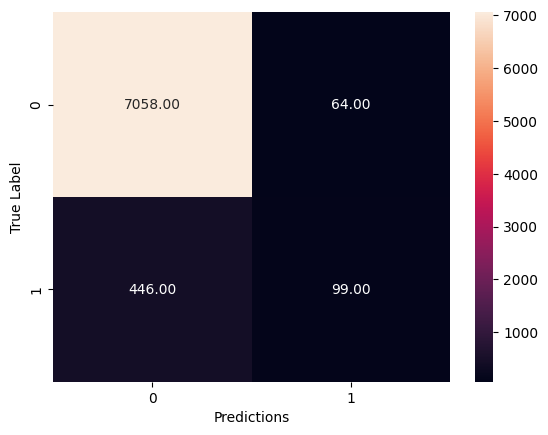

In [13]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, svc_preds)

sns.heatmap(conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [14]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, svc_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.18      0.97      0.42      0.19      7122
          1       0.61      0.18      0.99      0.28      0.42      0.17       545

avg / total       0.92      0.93      0.24      0.92      0.42      0.19      7667



In [15]:
duration_total = dummy_df['duration_minutes'].sum()/60 ## call time in hours for whole campaign

duration_mean = dummy_df['duration_minutes'].mean() ## average minutes per customer

true_negs = conf_matrix[0][0]*duration_mean/60 ## true negative hours

false_pos = conf_matrix[0][1]*duration_mean/60 ## false positive hours

svc_time_saved_pre_sampling = round(true_negs - false_pos, 2)

print(f"Total time saved without sampling techniques: {svc_time_saved_pre_sampling} hours")

Total time saved without sampling techniques: 495.65 hours


In [16]:
params = {
    'C': 10**np.linspace(-3,4,25)
}

grid = GridSearchCV(
    estimator=svc,
    param_grid=params,
    scoring=['recall', 'precision'],
    n_jobs=-1,
    cv=kfold,
    return_train_score=True,
    refit=False
)

grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=4701, shuffle=True),
             estimator=LinearSVC(dual='auto', max_iter=10000,
                                 random_state=4701),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.95734178e-03, 3.83118685e-03, 7.49894209e-03,
       1.46779927e-02, 2.87298483e-02, 5.62341325e-02, 1.10069417e-01,
       2.15443469e-01, 4.21696503e-01, 8.25404185e-01, 1.61559810e+00,
       3.16227766e+00, 6.18965819e+00, 1.21152766e+01, 2.37137371e+01,
       4.64158883e+01, 9.08517576e+01, 1.77827941e+02, 3.48070059e+02,
       6.81292069e+02, 1.33352143e+03, 2.61015722e+03, 5.10896977e+03,
       1.00000000e+04])},
             refit=False, return_train_score=True,
             scoring=['recall', 'precision'])

In [17]:
C_list = grid.cv_results_['param_C'].tolist()
C_list = [round(i, 4) for i in C_list]

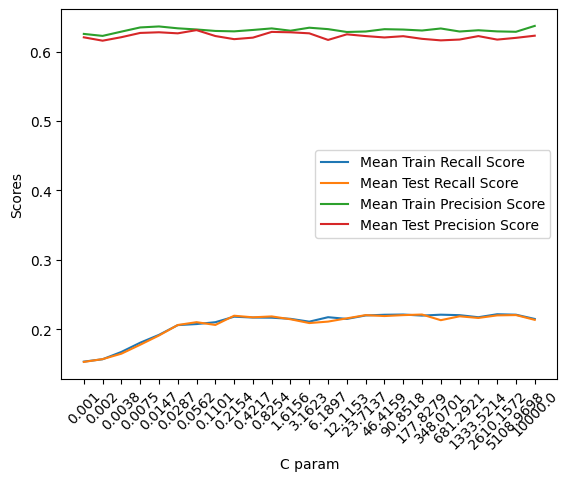

In [18]:
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_recall'], label='Mean Train Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_recall'], label='Mean Test Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_precision'], label='Mean Train Precision Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_precision'], label='Mean Test Precision Score')
plt.ylabel('Scores')
plt.xlabel('C param')
plt.xticks(np.arange(len(C_list)), labels=C_list, rotation=45)
plt.legend()
plt.show()

In [19]:
tuned_svc = LinearSVC(random_state=seed,
                      penalty='l2',
                      C=23.7137,
                      max_iter=10000,
                      dual='auto').fit(X_train, y_train)

tuned_svc_preds = tuned_svc.predict(X_test)

return_scores(tuned_svc, X_train, X_test, y_train, y_test)

,Recall,Precision
Train,0.215843,0.633159
Test,0.181651,0.607362


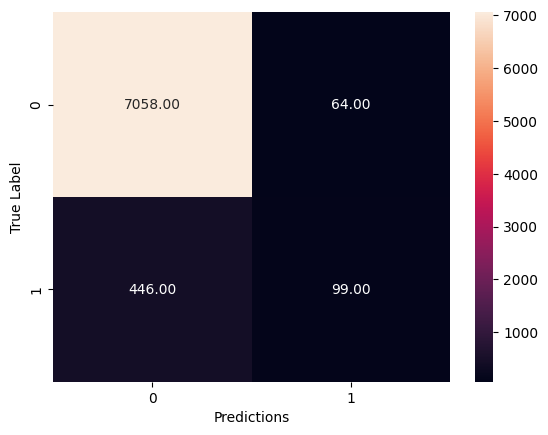

In [20]:
tuned_svc_conf_matrix = confusion_matrix(y_test, tuned_svc_preds)

sns.heatmap(tuned_svc_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [21]:
tuned_true_negs = tuned_svc_conf_matrix[0][0]*duration_mean/60 ## true negative hours

tuned_false_pos = tuned_svc_conf_matrix[0][1]*duration_mean/60 ## false positive hours

time_saved_after_tuning = round(tuned_true_negs - tuned_false_pos, 2)

print(f"Total time saved without sampling techniques: {time_saved_after_tuning} hours")

Total time saved without sampling techniques: 495.65 hours


In [22]:
print(classification_report_imbalanced(y_test, tuned_svc_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.18      0.97      0.42      0.19      7122
          1       0.61      0.18      0.99      0.28      0.42      0.17       545

avg / total       0.92      0.93      0.24      0.92      0.42      0.19      7667



After tuning the C paramater of a bare-bones LinearSVC model we do not have any substantial improvement on the model. 

We also see that the recall rate below 20% and looking at the confusion matrix above we see that the false negatives are fairly high (close to 500 customers).

The precision score is near 60% and the false positives (the customers we wish to minimize) are fairly low, resulting in a fairly decent amount of call time being reduced. In this case, close to 500 hours when using the average call time of the dataset.

### with Random Over Sampler

Using the sampling technique we saw in the pycaret graphic we will see if using a random oversample of the data makes any improvement on the recall score. Because of this, we will most likely sacrifice some call time saved to make sure the model captures more actual subscribers.

In [23]:
svc = LinearSVC(penalty='l2', random_state=seed, max_iter=10000, dual='auto')

In [24]:
svc.fit(X_ros, y_ros)

sampler_preds = svc.predict(X_test)

return_scores(svc, X_train, X_test, y_train, y_test)

,Recall,Precision
Train,0.860703,0.348030
Test,0.864220,0.334993


In [25]:
params = {
    'C': 10**np.linspace(-3,4,25)
}

grid = GridSearchCV(
    estimator=svc,
    param_grid=params,
    scoring=['recall', 'precision'],
    n_jobs=-1,
    cv=kfold,
    return_train_score=True,
    refit=False
)

grid.fit(X_ros, y_ros)

GridSearchCV(cv=KFold(n_splits=5, random_state=4701, shuffle=True),
             estimator=LinearSVC(dual='auto', max_iter=10000,
                                 random_state=4701),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.95734178e-03, 3.83118685e-03, 7.49894209e-03,
       1.46779927e-02, 2.87298483e-02, 5.62341325e-02, 1.10069417e-01,
       2.15443469e-01, 4.21696503e-01, 8.25404185e-01, 1.61559810e+00,
       3.16227766e+00, 6.18965819e+00, 1.21152766e+01, 2.37137371e+01,
       4.64158883e+01, 9.08517576e+01, 1.77827941e+02, 3.48070059e+02,
       6.81292069e+02, 1.33352143e+03, 2.61015722e+03, 5.10896977e+03,
       1.00000000e+04])},
             refit=False, return_train_score=True,
             scoring=['recall', 'precision'])

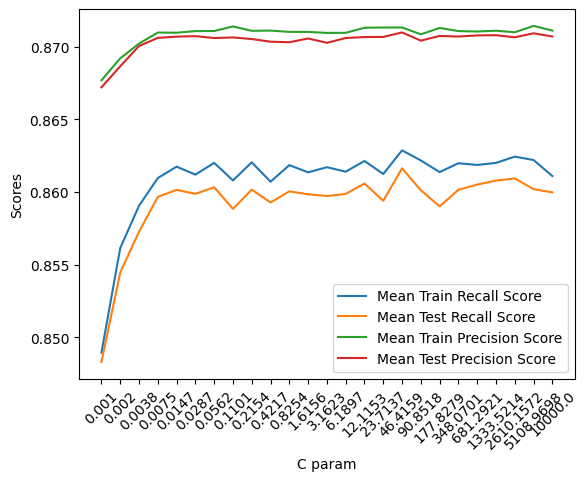

In [26]:
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_recall'], label='Mean Train Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_recall'], label='Mean Test Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_precision'], label='Mean Train Precision Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_precision'], label='Mean Test Precision Score')
plt.ylabel('Scores')
plt.xlabel('C param')
plt.xticks(np.arange(len(C_list)), labels=C_list, rotation=45)
plt.legend()
plt.show()

In [27]:
svc_ros_tuned = LinearSVC(penalty='l2', random_state=seed, C=.002, max_iter=10000, dual='auto')

svc_ros_tuned.fit(X_ros, y_ros)

LinearSVC(C=0.002, dual='auto', max_iter=10000, random_state=4701)

In [28]:
svc_ros_preds = svc_ros_tuned.predict(X_test)

return_scores(svc_ros_tuned, X_train, X_test, y_train, y_test)

,Recall,Precision
Train,0.857143,0.344852
Test,0.855046,0.331909


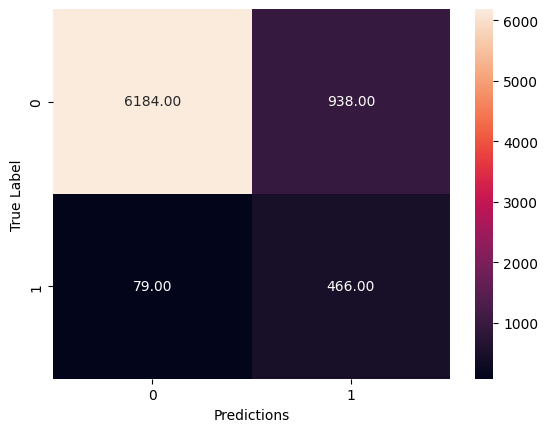

In [29]:
svc_ros_conf_matrix = confusion_matrix(y_test, svc_ros_preds)

sns.heatmap(svc_ros_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [30]:
print(classification_report_imbalanced(y_test, svc_ros_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.87      0.86      0.92      0.86      0.74      7122
          1       0.33      0.86      0.87      0.48      0.86      0.74       545

avg / total       0.94      0.87      0.86      0.89      0.86      0.74      7667



In [31]:
svc_ros_true_negs = svc_ros_conf_matrix[0][0]*duration_mean/60 ## hours

svc_ros_false_pos = svc_ros_conf_matrix[0][1]*duration_mean/60

svc_tuned_time_saved_post_samling = round(svc_ros_true_negs - svc_ros_false_pos, 2)

print(f"Total time saved with sampling techniques: {svc_tuned_time_saved_post_samling} hours")
print(f"Total time saved from base model: {svc_time_saved_pre_sampling}")

Total time saved with sampling techniques: 371.77 hours
Total time saved from base model: 495.65


Just as I explained above, a reduced amount of call time from the base model (120 extra hours) has resulted in a model than can capture ~86% of the subscribers in the dataset.

Next, we will look at l1 regularization to see how that compares to l2.

### l1 Regularization

In [32]:
svc_l1 = LinearSVC(penalty='l1', random_state=seed, dual=False, max_iter=10000).fit(X_train, y_train)

l1_preds = svc_l1.predict(X_test)

return_scores(svc_l1, X_train, X_test, y_train, y_test)

,Recall,Precision
Train,0.221629,0.633588
Test,0.183486,0.595238


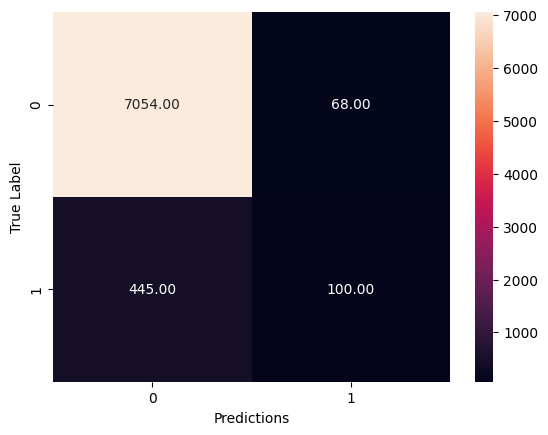

In [33]:
l1_conf_matrix = confusion_matrix(y_test, l1_preds)

sns.heatmap(l1_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [34]:
print(classification_report_imbalanced(y_test, l1_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.18      0.96      0.43      0.20      7122
          1       0.60      0.18      0.99      0.28      0.43      0.17       545

avg / total       0.92      0.93      0.24      0.92      0.43      0.19      7667



In [35]:
params = {
    'C': 10**np.linspace(-3,4,25)
}

grid = GridSearchCV(
    estimator=svc_l1,
    param_grid=params,
    scoring=['recall', 'precision'],
    n_jobs=-1,
    cv=kfold,
    return_train_score=True,
    refit=False
)

grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=4701, shuffle=True),
             estimator=LinearSVC(dual=False, max_iter=10000, penalty='l1',
                                 random_state=4701),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.95734178e-03, 3.83118685e-03, 7.49894209e-03,
       1.46779927e-02, 2.87298483e-02, 5.62341325e-02, 1.10069417e-01,
       2.15443469e-01, 4.21696503e-01, 8.25404185e-01, 1.61559810e+00,
       3.16227766e+00, 6.18965819e+00, 1.21152766e+01, 2.37137371e+01,
       4.64158883e+01, 9.08517576e+01, 1.77827941e+02, 3.48070059e+02,
       6.81292069e+02, 1.33352143e+03, 2.61015722e+03, 5.10896977e+03,
       1.00000000e+04])},
             refit=False, return_train_score=True,
             scoring=['recall', 'precision'])

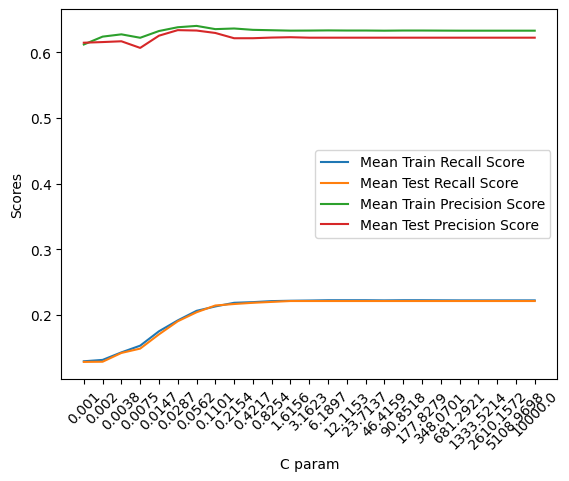

In [36]:
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_recall'], label='Mean Train Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_recall'], label='Mean Test Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_precision'], label='Mean Train Precision Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_precision'], label='Mean Test Precision Score')
plt.ylabel('Scores')
plt.xlabel('C param')
plt.xticks(np.arange(len(C_list)), labels=C_list, rotation=45)
plt.legend()
plt.show()

In [37]:
svc_l1_tuned = LinearSVC(penalty='l1',
                         random_state=seed,
                         dual=False,
                         C=.2154,
                         max_iter=10000).fit(X_train, y_train)

l1_tuned_preds = svc_l1_tuned.predict(X_test)

print('l1 tuned SVC scores:')
return_scores(svc_l1_tuned, X_train, X_test, y_train, y_test)

l1 tuned SVC scores:


,Recall,Precision
Train,0.218069,0.631443
Test,0.181651,0.607362


In [38]:
print('l2 tuned SVC scores:')
return_scores(tuned_svc, X_train, X_test, y_train, y_test)

l2 tuned SVC scores:


,Recall,Precision
Train,0.215843,0.633159
Test,0.181651,0.607362


Both tuned, base models show similar scores, but the l2 normalized SVC model shows a slight betterment than the l1 model.

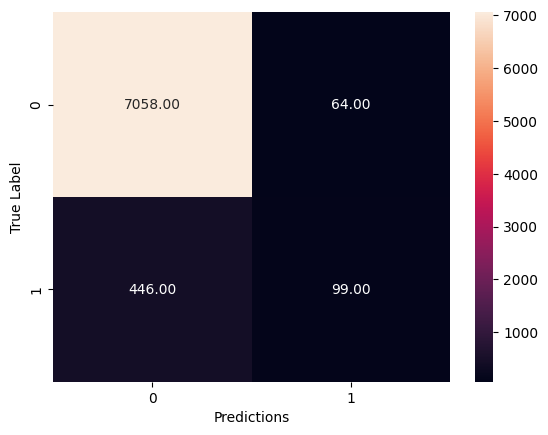

In [39]:
l1_tuned_conf_matrix = confusion_matrix(y_test, l1_tuned_preds)

sns.heatmap(l1_tuned_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [40]:
l1_tuned_true_negs = l1_tuned_conf_matrix[0][0]*duration_mean/60 ## hours

l1_tuned_false_pos = l1_tuned_conf_matrix[0][1]*duration_mean/60

l1_time_saved_pre_samling = round(l1_tuned_true_negs - l1_tuned_false_pos, 2)

print(f"Total time saved pre-sampling: {l1_time_saved_pre_samling} hours")

Total time saved pre-sampling: 495.65 hours


In [41]:
print(classification_report_imbalanced(y_test, l1_tuned_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.18      0.97      0.42      0.19      7122
          1       0.61      0.18      0.99      0.28      0.42      0.17       545

avg / total       0.92      0.93      0.24      0.92      0.42      0.19      7667



### l1 regularization with random over sampler

In [42]:
l1_svc_ros = LinearSVC(penalty='l1',
                       random_state=seed,
                       dual=False,
                       max_iter=10000).fit(X_ros, y_ros)

l1_ros_preds = l1_svc_ros.predict(X_test)

return_scores(l1_svc_ros, X_train, X_test, y_train, y_test)

,Recall,Precision
Train,0.861593,0.348829
Test,0.864220,0.335709


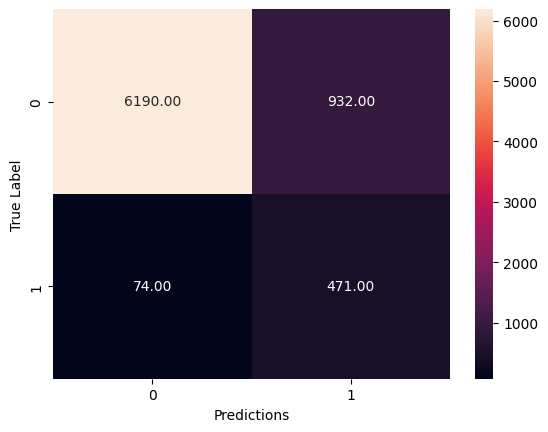

In [43]:
l1_ros_conf_matrix = confusion_matrix(y_test, l1_ros_preds)

sns.heatmap(l1_ros_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [44]:
l1_ros_true_negs = l1_ros_conf_matrix[0][0]*duration_mean/60 ## hours

l1_ros_false_pos = l1_ros_conf_matrix[0][1]*duration_mean/60

l1_time_saved_post_samling = round(l1_ros_true_negs - l1_ros_false_pos, 2)

print(f"Total time saved with sampling techniques: {l1_time_saved_post_samling} hours")

Total time saved with sampling techniques: 372.62 hours


In [45]:
params = {
    'C': 10**np.linspace(-3,4,25)
}

grid = GridSearchCV(
    estimator=l1_svc_ros,
    param_grid=params,
    scoring=['recall', 'precision'],
    n_jobs=-1,
    cv=kfold,
    return_train_score=True,
    refit=False
)

grid.fit(X_ros, y_ros)

GridSearchCV(cv=KFold(n_splits=5, random_state=4701, shuffle=True),
             estimator=LinearSVC(dual=False, max_iter=10000, penalty='l1',
                                 random_state=4701),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.95734178e-03, 3.83118685e-03, 7.49894209e-03,
       1.46779927e-02, 2.87298483e-02, 5.62341325e-02, 1.10069417e-01,
       2.15443469e-01, 4.21696503e-01, 8.25404185e-01, 1.61559810e+00,
       3.16227766e+00, 6.18965819e+00, 1.21152766e+01, 2.37137371e+01,
       4.64158883e+01, 9.08517576e+01, 1.77827941e+02, 3.48070059e+02,
       6.81292069e+02, 1.33352143e+03, 2.61015722e+03, 5.10896977e+03,
       1.00000000e+04])},
             refit=False, return_train_score=True,
             scoring=['recall', 'precision'])

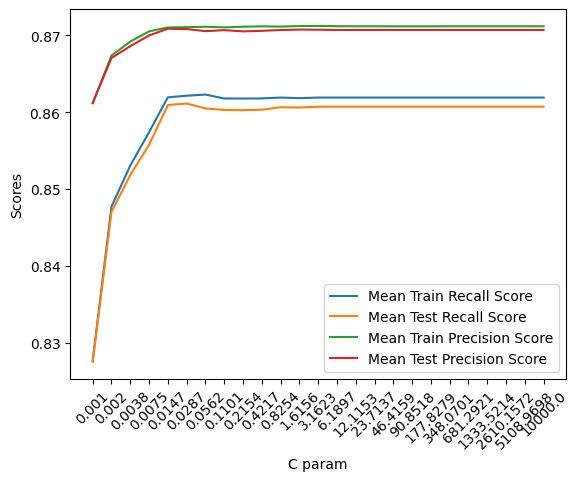

In [46]:
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_recall'], label='Mean Train Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_recall'], label='Mean Test Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_precision'], label='Mean Train Precision Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_precision'], label='Mean Test Precision Score')
plt.ylabel('Scores')
plt.xlabel('C param')
plt.xticks(np.arange(len(C_list)), labels=C_list, rotation=45)
plt.legend()
plt.show()

In [47]:
l1_ros_svc_tuned = LinearSVC(penalty='l1',
                       random_state=seed,
                       dual=False,
                       max_iter=10000,
                       C=.002).fit(X_ros, y_ros)

l1_ros_svc_preds_tuned = l1_ros_svc_tuned.predict(X_test)

return_scores(l1_ros_svc_tuned, X_train,X_test, y_train, y_test)

,Recall,Precision
Train,0.850467,0.342596
Test,0.844037,0.330697


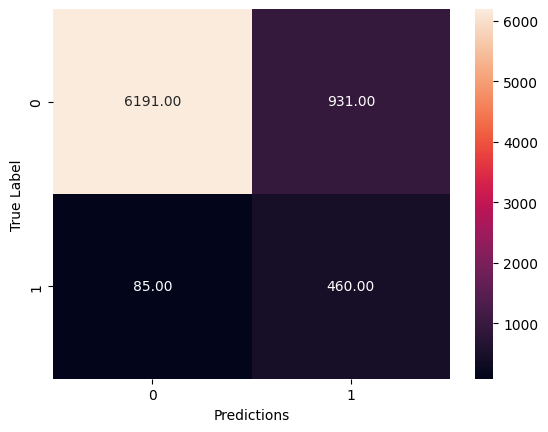

In [48]:
l1_ros_tuned_conf_matrix = confusion_matrix(y_test, l1_ros_svc_preds_tuned)

sns.heatmap(l1_ros_tuned_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [49]:
l1_ros_tuned_true_negs = l1_ros_tuned_conf_matrix[0][0]*duration_mean/60 ## hours

l1_ros_tuned_false_pos = l1_ros_tuned_conf_matrix[0][1]*duration_mean/60

l1_tuned_time_saved_post_samling = round(l1_ros_tuned_true_negs - l1_ros_tuned_false_pos, 2)

print(f"Total time saved with l2 LinearSVC using randomoversampling technique: {l1_tuned_time_saved_post_samling} hours")
print(f"Total time saved with l1 LinearSVC using randomoversampling technique: {svc_tuned_time_saved_post_samling} hours")

Total time saved with l2 LinearSVC using randomoversampling technique: 372.76 hours
Total time saved with l1 LinearSVC using randomoversampling technique: 371.77 hours


In [50]:
print('l1 SVC model with ROS technique:')
return_scores(l1_ros_svc_tuned, X_train,X_test, y_train, y_test)

l1 SVC model with ROS technique:


,Recall,Precision
Train,0.850467,0.342596
Test,0.844037,0.330697


In [51]:
print('l2 SVC model with ROS technique:')
return_scores(svc_ros_tuned, X_train,X_test, y_train, y_test)

l2 SVC model with ROS technique:


,Recall,Precision
Train,0.857143,0.344852
Test,0.855046,0.331909


From the two tables above we see that the l2 LinearSVC model performs slightly better with the random oversampling.

The call time saved is roughly equal with the l2 model performing slightly worse but only by .3 hours.

### Whole Dataset

In [52]:
dummy_df.head()

,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,0,4.350000,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,0,2.516667,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,0,1.266667,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,0,2.316667,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,0,3.616667,False,...,False,False,False,False,False,False,False,True,False,False


In [53]:
y = dummy_df['y'].values
X = dummy_df.drop('y', axis=1)
X.head()

,age,default,balance,housing,loan,day,campaign,duration_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,4.350000,False,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,2.516667,False,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,1.266667,False,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,2.316667,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,3.616667,False,False,...,False,False,False,False,False,False,False,True,False,False


In [54]:
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(
    X, y, random_state=seed, train_size=.80, shuffle=True
)

X_train_whole_ros, y_train_whole_ros = ros.fit_resample(X_train_whole, y_train_whole)

In [55]:
svc_ros_tuned.C

0.002

In [56]:
final_svc = LinearSVC(penalty='l2',
                         random_state=seed,
                         dual='auto',
                         max_iter=10000,
                         C=.002)
            
final_svc.fit(X_train_whole_ros, y_train_whole_ros)

LinearSVC(C=0.002, dual='auto', max_iter=10000, random_state=4701)

In [57]:
svc_whole_preds = final_svc.predict(X_test_whole)

return_scores(final_svc, X_train_whole, X_test_whole, y_train_whole, y_test_whole)

,Recall,Precision
Train,0.857143,0.344852
Test,0.855046,0.331909


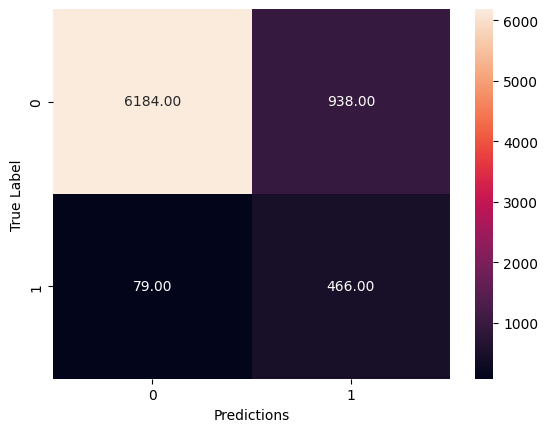

In [58]:
whole_conf_matrix = confusion_matrix(y_test_whole, svc_whole_preds)

sns.heatmap(whole_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [59]:
whole_true_negs = whole_conf_matrix[0][0]*duration_mean/60
whole_false_pos = whole_conf_matrix[0][1]*duration_mean/60

whole_time_saved = round(whole_true_negs - whole_false_pos, 2)

print(f"Whole time saved: {whole_time_saved} hours")

Whole time saved: 371.77 hours


In [60]:
print(classification_report_imbalanced(y_test, svc_whole_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.87      0.86      0.92      0.86      0.74      7122
          1       0.33      0.86      0.87      0.48      0.86      0.74       545

avg / total       0.94      0.87      0.86      0.89      0.86      0.74      7667



Using the whole dataset with both demographic data and campaign data, the tuned LinearSVC model using a random over-sampling technique classifies ~86% of the customers who subscribed to the term deposit product.

This model subsequently saves call center employees over 371 hours of wasted call time to customers who would ultimately not subscribe.

The next notebook we'll look at next is the Ridge Classifier notebook...

In [61]:
coef_df = pd.DataFrame({
    'Coefficients': final_svc.coef_[0]
}, index=X_train.columns).sort_values(by='Coefficients', ascending=True)

coef_df

,Coefficients
month_jan,-0.772938
month_aug,-0.527919
contact_unknown,-0.479876
month_jul,-0.477701
month_nov,-0.361324
housing,-0.257699
job_housemaid,-0.195654
loan,-0.152051
marital_married,-0.151666
education_primary,-0.136024


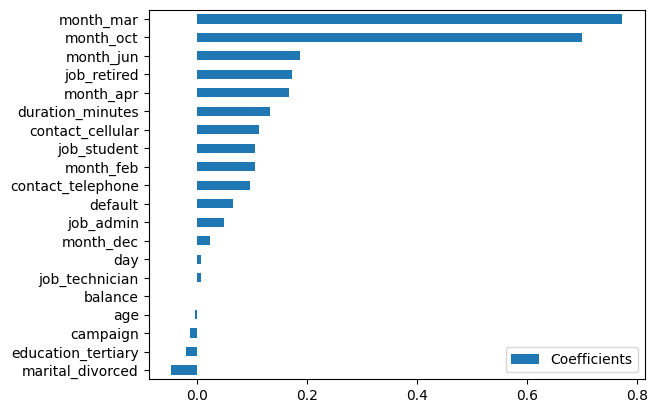

In [62]:
coef_df.tail(20).plot(kind='barh')
plt.show()